# Run Any Kind of Logistic Regression (Binomial, Multinomial, etc.)

### Authors: Calvin Howard.

#### Last updated: March 16, 2024

Use this to run/test a statistical model on a spreadsheet.

Notes:
- To best use this notebook, you should be familar with GLM design and Contrast Matrix design. See this webpage to get started:
[FSL's GLM page](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM)

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [1]:
# %pip install seaborn --upgrade

Prep Output Directory

In [2]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/cortical_thicknes'

Import Data

In [3]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/cortical_thickness/differential_diagnoses_train_CT_jan13.csv'
sheet = None

In [4]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
data_df

,DX,subid,AD,SV,LBD,BV,PNFA,CBS,PSP,CN,Peak_Values
0,AD,002_S_5018,0.792234,0.637130,0.770520,0.711657,0.741938,0.741759,0.751960,0.778796,0.977918
1,AD,003_S_4136,0.698004,0.541441,0.697240,0.664413,0.627885,0.639614,0.655714,0.681190,0.031744
2,AD,003_S_4152,0.710199,0.464189,0.721739,0.734623,0.733545,0.686729,0.699635,0.698206,1.282207
3,AD,003_S_4373,0.742413,0.586996,0.689886,0.646002,0.718025,0.714775,0.692431,0.712252,0.859213
4,AD,003_S_4892,0.787148,0.624036,0.770895,0.713148,0.747336,0.754323,0.751406,0.788459,1.177357
...,...,...,...,...,...,...,...,...,...,...,...
472,CN,130_S_4343,0.820439,0.612870,0.817282,0.770483,0.803333,0.810117,0.813656,0.835698,1.139855
473,CN,135_S_4566,0.801270,0.604334,0.753413,0.697122,0.760507,0.799688,0.779230,0.786925,1.219154
474,CN,137_S_4520,0.828650,0.600227,0.836563,0.776609,0.810572,0.835810,0.830756,0.857019,1.055402
475,CN,137_S_4632,0.820463,0.619128,0.834255,0.801400,0.808762,0.823134,0.830933,0.845885,1.071962


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [5]:
drop_list = ['DX']

In [6]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

,DX,subid,AD,SV,LBD,BV,PNFA,CBS,PSP,CN,Peak_Values
0,AD,002_S_5018,0.792234,0.637130,0.770520,0.711657,0.741938,0.741759,0.751960,0.778796,0.977918
1,AD,003_S_4136,0.698004,0.541441,0.697240,0.664413,0.627885,0.639614,0.655714,0.681190,0.031744
2,AD,003_S_4152,0.710199,0.464189,0.721739,0.734623,0.733545,0.686729,0.699635,0.698206,1.282207
3,AD,003_S_4373,0.742413,0.586996,0.689886,0.646002,0.718025,0.714775,0.692431,0.712252,0.859213
4,AD,003_S_4892,0.787148,0.624036,0.770895,0.713148,0.747336,0.754323,0.751406,0.788459,1.177357
...,...,...,...,...,...,...,...,...,...,...,...
472,CN,130_S_4343,0.820439,0.612870,0.817282,0.770483,0.803333,0.810117,0.813656,0.835698,1.139855
473,CN,135_S_4566,0.801270,0.604334,0.753413,0.697122,0.760507,0.799688,0.779230,0.786925,1.219154
474,CN,137_S_4520,0.828650,0.600227,0.836563,0.776609,0.810572,0.835810,0.830756,0.857019,1.055402
475,CN,137_S_4632,0.820463,0.619128,0.834255,0.801400,0.808762,0.823134,0.830933,0.845885,1.071962


**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

In [7]:
data_df.columns

Index(['DX', 'subid', 'AD', 'SV', 'LBD', 'BV', 'PNFA', 'CBS', 'PSP', 'CN',
       'Peak_Values'],
      dtype='object')

Set the parameters for dropping rows

In [8]:
# column = 'Cohort'  # The column you'd like to evaluate
# condition = 'equal'  # The condition to check ('equal', 'above', 'below', 'not')
# value = 0 # The value to drop if found

In [9]:
# data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
# display(data_df)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [10]:
# Remove anything you don't want to standardize
# cols_not_to_standardize = ['DX', 'SUBID'] # ['Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group', 'Z_Scored_Subiculum_T_By_Origin_Group_'] #['Age']


In [11]:
# data_df = cal_palm.standardize_columns(cols_not_to_standardize)
# data_df

# 00 - Define Your Formula

This is the formula relating outcome to predictors, and takes the form:
- y = B0 + B1 + B2 + B3 + . . . BN

It is defined using the columns of your dataframe instead of the variables above:
- 'Apples_Picked ~ hours_worked + owns_apple_picking_machine'

____
**Normal Logistic**
- Assesses the impact of multiple predictors on an outcome.
- formula = 'Binary Outcome ~ Predictor1 + Predictor2'

**Multiple Logistic**
- Assesses the impact of predictor on an outcome.
- formula = 'Ordinal Outcome ~ Predictor1 + Predictor2'

____
Use the printout below to design your formula. 
- Left of the "~" symbol is the thing to be predicted. 
- Right of the "~" symbol are the predictors. 
- ":" indicates an interaction between two things. 
- "*" indicates and interactions AND it accounts for the simple effects too. 
- "+" indicates that you want to add another predictor. 

In [12]:
data_df.columns

Index(['DX', 'subid', 'AD', 'SV', 'LBD', 'BV', 'PNFA', 'CBS', 'PSP', 'CN',
       'Peak_Values'],
      dtype='object')

In [13]:
formula = "DX ~ AD + SV + LBD + BV + PNFA + CBS + PSP + CN + Peak_Values"

# 02 - Visualize Your Design Matrix

This is the explanatory variable half of your regression formula
_______________________________________________________
Create Design Matrix: Use the create_design_matrix method. You can provide a list of formula variables which correspond to column names in your dataframe.

- design_matrix = palm.create_design_matrix(formula_vars=["var1", "var2", "var1*var2"])
- To include interaction terms, use * between variables, like "var1*var2".
- By default, an intercept will be added unless you set intercept=False
- **don't explicitly add the 'intercept' column. I'll do it for you.**

In [14]:
# Define the design matrix
outcome_matrix, design_matrix = cal_palm.define_design_matrix(formula, data_df)
design_matrix

,Intercept,AD,SV,LBD,BV,PNFA,CBS,PSP,CN,Peak_Values
0,1.0,0.792234,0.637130,0.770520,0.711657,0.741938,0.741759,0.751960,0.778796,0.977918
1,1.0,0.698004,0.541441,0.697240,0.664413,0.627885,0.639614,0.655714,0.681190,0.031744
2,1.0,0.710199,0.464189,0.721739,0.734623,0.733545,0.686729,0.699635,0.698206,1.282207
3,1.0,0.742413,0.586996,0.689886,0.646002,0.718025,0.714775,0.692431,0.712252,0.859213
4,1.0,0.787148,0.624036,0.770895,0.713148,0.747336,0.754323,0.751406,0.788459,1.177357
...,...,...,...,...,...,...,...,...,...,...
472,1.0,0.820439,0.612870,0.817282,0.770483,0.803333,0.810117,0.813656,0.835698,1.139855
473,1.0,0.801270,0.604334,0.753413,0.697122,0.760507,0.799688,0.779230,0.786925,1.219154
474,1.0,0.828650,0.600227,0.836563,0.776609,0.810572,0.835810,0.830756,0.857019,1.055402
475,1.0,0.820463,0.619128,0.834255,0.801400,0.808762,0.823134,0.830933,0.845885,1.071962


Check multicollinearity in design matrix

In [15]:
#Multico. Check
from calvin_utils.statistical_utils.statistical_measurements import calculate_vif
calculate_vif(design_matrix)

,features,VIF
0,Intercept,151.426899
1,AD,68.208801
2,SV,3.363296
3,LBD,139.590667
4,BV,38.184535
5,PNFA,83.025702
6,CBS,332.240459
7,PSP,380.940978
8,CN,211.860392
9,Peak_Values,1.160174


# 03 - Visualize Your Dependent Variable

I have generated this for you based on the formula you provided

In [16]:
# outcome_matrix = outcome_matrix.iloc[:, [0]]
outcome_matrix

,DX[AD],DX[BV],DX[CBS],DX[CN],DX[LBD],DX[PNFA],DX[PSP],DX[SV]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
472,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
473,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
474,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
475,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**CRITICAL IN MULTINOMIAL LOGISTIC REGRESSION**
- A multinomial logistic reg. will set results RELATIVE TO A REFERENCE class. 
- The reference class is the first classification the multinomial encounters.
- **Especially if you are running a multinomial logistic regression, set your reference class below**

In [17]:
reference = 'Diagnosis[Control]'

# 04 - Run the Regression

Regression Results Are Displayed Below

- This will run a binomial or a multinomial logit dependig on your outcome matrix. 
- A multinomial logit will display N-1 categories, where N is the number of potential classifications you have. This occurs because everything is set in reference to that class. 
- So, the reference will either be the first column in your outcomes_matrix, or you can manually set it first.

In [18]:
from calvin_utils.statistical_utils.logistic_regression import LogisticRegression
logreg = LogisticRegression(outcome_matrix, design_matrix)
results = logreg.run()
results.summary2()

Optimization terminated successfully.
         Current function value: nan
         Iterations 14
----INTERPRETATION KEY----
reference_category : DX[AD]
y=0 : DX[BV]
y=1 : DX[CBS]
y=2 : DX[CN]
y=3 : DX[LBD]
y=4 : DX[PNFA]
y=5 : DX[PSP]
y=6 : DX[SV]
<bound method MultinomialResults.summary2 of <statsmodels.discrete.discrete_model.MultinomialResults object at 0x29bef7c50>>


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: MNLogit
==============================================================
Model:              MNLogit          Method:           MLE    
Dependent Variable: y                Pseudo R-squared: nan    
Date:               2025-02-05 13:07 AIC:              nan    
No. Observations:   477              BIC:              nan    
Df Model:           63               Log-Likelihood:   nan    
Df Residuals:       407              LL-Null:          -858.70
Converged:          1.0000           LLR p-value:      nan    
No. Iterations:     14.0000          Scale:            1.0000 
--------------------------------------------------------------
   y = 0      Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
--------------------------------------------------------------
  Intercept     nan        nan   nan     nan      nan      nan
         AD     nan        nan   nan     nan      nan      nan
         SV     nan        nan   nan     nan      nan      nan
        LBD     nan        nan   nan     nan      nan      nan
         BV     nan        nan   nan     nan      nan      nan
       PNFA     nan        nan   nan     nan      nan      nan
        CBS     nan        nan   nan     nan      nan      nan
        PSP     nan        nan   nan     nan      nan      nan
         CN     nan        nan   nan     nan      nan      nan
Peak_Values     nan        nan   nan     nan      nan      nan
--------------------------------------------------------------
   y = 1      Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
--------------------------------------------------------------
  Intercept     nan        nan   nan     nan      nan      nan
         AD     nan        nan   nan     nan      nan      nan
         SV     nan        nan   nan     nan      nan      nan
        LBD     nan        nan   nan     nan      nan      nan
         BV     nan        nan   nan     nan      nan      nan
       PNFA     nan        nan   nan     nan      nan      nan
        CBS     nan        nan   nan     nan      nan      nan
        PSP     nan        nan   nan     nan      nan      nan
         CN     nan        nan   nan     nan      nan      nan
Peak_Values     nan        nan   nan     nan      nan      nan
--------------------------------------------------------------
   y = 2      Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
--------------------------------------------------------------
  Intercept     nan        nan   nan     nan      nan      nan
         AD     nan        nan   nan     nan      nan      nan
         SV     nan        nan   nan     nan      nan      nan
        LBD     nan        nan   nan     nan      nan      nan
         BV     nan        nan   nan     nan      nan      nan
       PNFA     nan        nan   nan     nan      nan      nan
        CBS     nan        nan   nan     nan      nan      nan
        PSP     nan        nan   nan     nan      nan      nan
         CN     nan        nan   nan     nan      nan      nan
Peak_Values     nan        nan   nan     nan      nan      nan
--------------------------------------------------------------
   y = 3      Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
--------------------------------------------------------------
  Intercept     nan        nan   nan     nan      nan      nan
         AD     nan        nan   nan     nan      nan      nan
         SV     nan        nan   nan     nan      nan      nan
        LBD     nan        nan   nan     nan      nan      nan
         BV     nan        nan   nan     nan      nan      nan
       PNFA     nan        nan   nan     nan      nan      nan
        CBS     nan        nan   nan     nan      nan      nan
        PSP     nan        nan   nan     nan      nan      nan
         CN     nan        nan   nan     nan      nan      nan
Peak_Values     nan        nan   nan     nan      nan      nan
--------------------------------------------------------------
   y 

# 6 - Receiver Operating Characteristic
- The ROC considers clasisfications acoss ALL POSSIBLE PROBABILITIES, demonstrating what is ultiamtely accomplishable at the best possible threshold

- First curve is ROC for classifcation of each class with respect to all other classes
- Second Curve (Macro Average) is basically a meta-analytic ROC with equal weight per class.
- Third Curve (Micro Average) is basically a meta-analytic ROC with weight proportional to class sample

Taking maximum probability as prediction.
There are 112.0 observations for DX[AD]
There are 45.0 observations for DX[BV]
There are 31.0 observations for DX[CBS]
There are 170.0 observations for DX[CN]
There are 30.0 observations for DX[LBD]
There are 28.0 observations for DX[PNFA]
There are 32.0 observations for DX[PSP]
There are 29.0 observations for DX[SV]


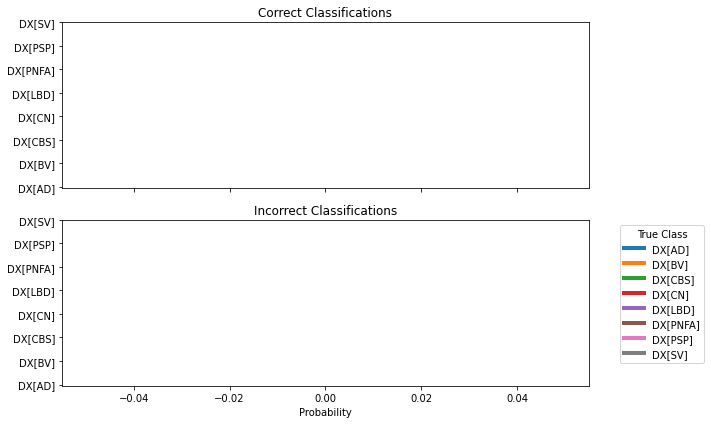

ValueError: Input contains NaN.

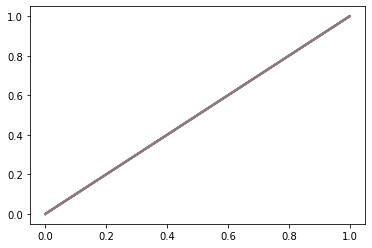

In [19]:
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
evaluator = ComprehensiveMulticlassROC(fitted_model=results, observation_df=outcome_matrix, normalization='true', thresholds=None, out_dir=out_dir+'/train_results')
evaluator.run()

ADVANCED
- code specific manual thresholds to intervene upon classifications

Step 1: relate integer (index) to class

In [20]:
# evaluator.relate_index_to_class()

Step 2: in a dictionary of the indices (corresponding to class), key in the lambda function to edit the probability. 
- Code from left to right, giving priority to each method. 
- Example:
```
>thresholds = {
>            0: lambda probs: 0 if probs[0] > 0.5 else (1 if probs[0] > 0.25 else 2),  # Adjust class_0 predictions
>            1: lambda probs: None,  # No threshold adjustment for class_1
>            2: lambda probs: None   # No threshold adjustment for class_2
>        }
```

In [21]:
# thresholds = {
#     0: lambda prob: 0,  # Always keep class 0
#     1: lambda prob: 1,  # Always keep class 1
#     2: lambda prob: 2 if prob[2] > 0.5 else (1 if prob[1] > 0.3 else 0)  # Conditional adjustment for class 2
# }


Step 3: Check the effect

In [22]:
# from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
# evaluator = ComprehensiveMulticlassROC(fitted_model=results, observation_df=outcome_matrix, normalization='pred', thresholds=thresholds, out_dir=out_dir)
# evaluator.run()

Step 4: YOU MUST LOOCV AND VALIDATE IN OUT-OF-SAMPLE DATA.
- add thresholds as an argument to any further calls to ComprehensiveMulticlassROC

Bootstrap the Micro Average AUC

In [23]:
# import matplotlib
# from calvin_utils.statistical_utils.classification_statistics import bootstrap_auc
# matplotlib.use('Agg')  # Use a non-interactive backend

# mean_auc, lower_ci, upper_ci = bootstrap_auc(outcome_matrix, design_matrix, n_iterations=1000)
# print(f'Mean AUC: {mean_auc}, 95% CI: ({lower_ci}, {upper_ci})')

Permutation Test Two AUCs

In [ ]:
data_df.columns

In [25]:
# f1 = "Diagnosis ~ CerebellumCSF + ParietalCSF + MTLCSF + OccipitalCSF + FrontalCSF + temp_ins_csf + SubcortexCSF"
# f2 = "Diagnosis ~ CerebellumGM + ParietalGM + MTLGM + OccipitalGM + FrontalGM + temp_ins_gm + SubcortexGM"

In [26]:
# import matplotlib
# matplotlib.use('Agg')  # Use a non-interactive backend
# from calvin_utils.statistical_utils.classification_statistics import permute_auc_difference
# obs_diff, lower_ci, upper_ci, p_value = permute_auc_difference(data_df, formula1=f1, 
#                                                                   formula2=f2,
#                                                                   cal_palm=cal_palm, n_iterations=1000)
# print(f'Observde AUC Difference: {obs_diff}, 95% CI: ({lower_ci}, {upper_ci}), p-value: {p_value}')

# 06 - Visualize the Regression as a Forest Plot
- This will probably look poor if you ran a regression without standardizing your data. 

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import MultinomialForestPlot

multinomial_forest = MultinomialForestPlot(model=results, sig_digits=2, out_dir=out_dir+'/forest_plots', table=False)
multinomial_forest.run()

# 07 - Generate Partial Dependence Plots

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import PartialDependencePlot
pdp = PartialDependencePlot(formula=formula, data_df=data_df, model=results, design_matrix=design_matrix, outcomes_df=outcome_matrix, data_range=[-1,1], out_dir=out_dir+'/partial_dep_plots', marginal_method='mean', debug=False)
pdp.run()

# 08 - Visualize the Partial Regression Plots

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import PartialRegressionPlot
partial_plot = PartialRegressionPlot(model=results, design_matrix=design_matrix, out_dir=out_dir+'/partial_regression_plot', palette=None)
partial_plot = partial_plot.run()

# 09 - LOOCV

In [ ]:
import pandas as pd
from calvin_utils.statistical_utils.logistic_regression import LogisticRegression
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
y_true, y_pred, test_prob = LogisticRegression.run_loocv(outcome_matrix, design_matrix)
loocv_evaluator = ComprehensiveMulticlassROC(fitted_model=None, predictions_df=pd.DataFrame(test_prob, columns=outcome_matrix.columns), observation_df=outcome_matrix, normalization='pred', thresholds=None, out_dir=out_dir+'/loocv_results')
loocv_evaluator.run()

# 10 - Predict Unseen Data

In [31]:
new_csv_path='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/cortical_thickness/differential_diagnoses_test_CT_jan13.csv'

Optional - Get New Data

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# # Instantiate the PalmPrepararation class
new_palm = CalvinStatsmodelsPalm(input_csv_path=new_csv_path, output_dir=out_dir+'/test_results', sheet=sheet)
# Call the process_nifti_paths method
other_df = new_palm.read_and_display_data()
other_df

In [33]:
# formula

In [34]:
# column_renaming_map = {
#                        'Mesial_Temporal': 'mesial_temporal_eh', 
#                        'parietal': 'parietal_eh', 
#                        'frontal': 'frontal_eh',
#                        'temporal': 'temporal_eh', 
#                        'ventricle':'ventricle_eh',
#                        'occipital': 'occipital_eh'}

In [35]:
# other_df.rename(columns=column_renaming_map, inplace=True)

Prepare Data

In [ ]:
# Define the design matrix
# subset_df = other_df.groupby('DIAGNOSIS_BL').apply(lambda x: x.sample(min(len(x), 200))).reset_index(drop=True)
import pandas as pd
other_outcome_matrix, other_design_matrix = cal_palm.define_design_matrix(formula, other_df)

# Ensure both matrices have the same columns
if len(other_outcome_matrix.columns) != len(outcome_matrix.columns):
    # Create a zero-filled DataFrame with the same columns as outcome_matrix
    zero_df = pd.DataFrame(0, index=other_outcome_matrix.index, columns=outcome_matrix.columns)
    
    # Fill zero_df with values from other_outcome_matrix where columns exist
    common_columns = other_outcome_matrix.columns.intersection(outcome_matrix.columns)
    zero_df.loc[:, common_columns] = other_outcome_matrix.loc[:, common_columns]
    
    other_outcome_matrix = zero_df

other_design_matrix


Predict

Evaluate

In [ ]:
formula

In [38]:
# thresholds = {
#     0: lambda prob: 0 if prob < 0.33 else 1,
#     1: lambda prob: 1 if prob > 0.33 else 0
# }

In [ ]:
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
loocv_evaluator = ComprehensiveMulticlassROC(fitted_model=None, predictions_df=results.predict(other_design_matrix), observation_df=other_outcome_matrix, normalization='true', thresholds=None, out_dir=out_dir+'/test_results')
loocv_evaluator.run() 

In [40]:
# results.predict(other_design_matrix)
loocv_evaluator.predictions_df.to_csv(out_dir+'/test_results/predicted_probabilities.csv')

Get One Vs. All Confidence Intervals on AUC

In [ ]:
df, bootstrap = ComprehensiveMulticlassROC.bootstrap_ovr_auroc(raw_observations=loocv_evaluator.raw_observations, raw_predictions=loocv_evaluator.raw_predictions, outcome_matrix_cols=loocv_evaluator.outcome_matrix.columns)
ComprehensiveMulticlassROC.plot_ovr_auc_with_ci(df, out_dir=out_dir+'/test_auc_per_diagnosis')

In [ ]:
display(df)

Get Confidence Intervals on Sensitivity, Specificity, NPV, PPV, and Accuracy for Each Class

In [ ]:
from calvin_utils.statistical_utils.classification_statistics import calculate_youden_and_metrics, save_dfs
dfs = calculate_youden_and_metrics(raw_observations=loocv_evaluator.raw_observations, raw_predictions=loocv_evaluator.raw_predictions, outcome_matrix_cols=loocv_evaluator.outcome_matrix.columns)
save_dfs(dfs, out_dir=out_dir+'/metrics_per_diagnosis')

Get Overall Micro Average AUC

In [ ]:
loocv_evaluator.get_micro_auc()

In [45]:

###----- Functionally Programmed Functions for Evaluation Using Above Classes -----##
'''
Hanging imports to facilitate easy transplant of code.
'''
import numpy as np
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
from calvin_utils.statistical_utils.logistic_regression import LogisticRegression
import os
from contextlib import redirect_stdout, redirect_stderr
from tqdm import tqdm

def resample_df(data_df):
    n_samples = data_df.shape[0]
    # Shuffle the indices
    shuffled_indices = np.random.permutation(n_samples)
    # Reorder the DataFrame based on the shuffled indices but keep the original index
    shuffled_df = data_df.iloc[shuffled_indices].reset_index(drop=True).set_index(data_df.index)
    return shuffled_df

def permute_auc_difference(data_df, formula1, formula2, cal_palm, n_iterations=1000):
    auc_diffs = []
    for i in tqdm(range(n_iterations)):
        try:
            with open(os.devnull, 'w') as fnull, redirect_stdout(fnull), redirect_stderr(fnull):
                # Define design matrices and outcome matrices for both formulas
                outcome_matrix, design_matrix1 = cal_palm.define_design_matrix(formula1, data_df)
                _, design_matrix2 = cal_palm.define_design_matrix(formula2, data_df)
                
                # Permute the outcomes
                if i == 0:
                    resampled_df = outcome_matrix
                else:
                    resampled_df = resample_df(outcome_matrix)

                # Fit the logistic regression model for the first formula
                logreg1 = LogisticRegression(resampled_df, design_matrix1)
                results1 = logreg1.run()

                # Fit the logistic regression model for the second formula
                logreg2 = LogisticRegression(resampled_df, design_matrix2)
                results2 = logreg2.run()

                # Evaluate the models
                evaluator1 = ComprehensiveMulticlassROC(fitted_model=results1, observation_df=resampled_df, normalization='true', thresholds=None, out_dir=None)
                micro_auc1 = evaluator1.get_micro_auc()

                evaluator2 = ComprehensiveMulticlassROC(fitted_model=results2, observation_df=resampled_df, normalization='true', thresholds=None, out_dir=None)
                micro_auc2 = evaluator2.get_micro_auc()

                # Store the difference in micro-average AUCs
                if i == 0:
                    obs_diff = micro_auc1 - micro_auc2
                    print(f"F1: {micro_auc1} | F2: {micro_auc2}")
                else:
                    auc_diffs.append(micro_auc1 - micro_auc2)
            
        except Exception as e:
            print(e)
            continue
    # Calculate p-value based on the distribution of differences
    auc_diffs = np.array(auc_diffs)
    p_value = np.mean(auc_diffs >= obs_diff)

    # Calculate confidence intervals for the difference
    lower_ci = np.percentile(auc_diffs, 2.5)
    upper_ci = np.percentile(auc_diffs, 97.5)
    
    return obs_diff, lower_ci, upper_ci, p_value

def bootstrap_auc(outcome_matrix, design_matrix, n_iterations=1000, model=None):
    auc_scores = []
    n_samples = outcome_matrix.shape[0]
    
    for i in tqdm(range(n_iterations)):
        # Suppress both stdout and stderr
        try:
            with open(os.devnull, 'w') as fnull, redirect_stdout(fnull), redirect_stderr(fnull):
                # Generate a bootstrap sample
                resample_idx = np.random.choice(n_samples, size=n_samples, replace=True)
                outcome_matrix_resampled = outcome_matrix.iloc[resample_idx]
                design_matrix_resampled = design_matrix.iloc[resample_idx]

                # Fit the logistic regression model
                if model is None:
                    logreg = LogisticRegression(outcome_matrix_resampled, design_matrix_resampled)
                    results = logreg.run()
                    test = ComprehensiveMulticlassROC(fitted_model=results, observation_df=outcome_matrix_resampled, normalization='true', thresholds=None, out_dir=None)
                else:
                    results = model.predict(design_matrix_resampled)
                    test = ComprehensiveMulticlassROC(fitted_model=None, predictions_df=results, observation_df=outcome_matrix_resampled, normalization='true', thresholds=None, out_dir=None)
                # Evaluate the model
                micro_auc = test.get_micro_auc()
                auc_scores.append(micro_auc)
        except:
            continue
    # Calculate confidence intervals
    lower_ci = np.percentile(auc_scores, 2.5)
    upper_ci = np.percentile(auc_scores, 97.5)    
    return np.mean(auc_scores), lower_ci, upper_ci, auc_scores


Bootstrap the Micro Average AUC

In [ ]:
import matplotlib
# from calvin_utils.statistical_utils.classification_statistics import bootstrap_auc
matplotlib.use('Agg')  # Use a non-interactive backend
mean_auc, lower_ci, upper_ci, auc_dist = bootstrap_auc(other_outcome_matrix, other_design_matrix, n_iterations=1000, model=results)
print(f'Mean AUC: {mean_auc}, 95% CI: ({lower_ci}, {upper_ci})')

In [ ]:
import pandas as pd
auc_df = pd.DataFrame({'val':auc_dist})
auc_df.to_csv('/path/to/df.csv')

In [ ]:
auc_df = pd.read_csv('/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/atrophy_seeds_2023/Figures/diagnostic_ability/50fit_150pred/auc_dist.csv')

In [ ]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

def compare_bootstrapped_means(distribution1, distribution2):
    """
    Compares two bootstrapped distributions using a two-sample t-test and Mann-Whitney U test.
    
    Parameters:
    - distribution1 (list or array): Bootstrapped distribution of group 1.
    - distribution2 (list or array): Bootstrapped distribution of group 2.
    
    Returns:
    - t_stat (float): t-statistic from the two-sample t-test.
    - t_p_value (float): p-value from the two-sample t-test.
    - u_stat (float): U-statistic from the Mann-Whitney U test.
    - u_p_value (float): p-value from the Mann-Whitney U test.
    """
    # Perform a two-sample t-test to compare means
    t_stat, t_p_value = ttest_ind(distribution1, distribution2)
    
    # Perform a Mann-Whitney U test to compare distributions
    u_stat, u_p_value = mannwhitneyu(distribution1, distribution2)

    return t_stat, t_p_value, u_stat, u_p_value

# Compare the distributions
t_stat, t_p_value, u_stat, u_p_value = compare_bootstrapped_means(auc_df['CSF AUCs'], auc_df['CTh AUCs'])

print(f"Two-sample t-test: t-stat = {t_stat:.4f}, p-value = {t_p_value:.4f}")
print(f"Mann-Whitney U test: U-stat = {u_stat:.4f}, p-value = {u_p_value:.4f}")


Plot Bootstraps

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_custom_bootstrap_auc(df):
    """
    Plots the mean and error bars of AUCs for each column in the DataFrame using Seaborn and Matplotlib,
    styled similarly to the reference plot.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing bootstrapped AUC distributions. 
                         Each column represents a different group.
    """
    # Initialize lists to store plotting data
    means = []
    lower_errors = []
    upper_errors = []
    y_labels = []

    # Calculate mean and confidence intervals for each column in the DataFrame, ignoring NaNs
    for column in df.columns:
        bootstrapped_values = df[column].dropna()  # Remove NaN values
        if len(bootstrapped_values) > 0:
            mean_value = np.mean(bootstrapped_values)
            lower_ci = np.percentile(bootstrapped_values, 2.5)
            upper_ci = np.percentile(bootstrapped_values, 97.5)
            
            means.append(mean_value)
            lower_errors.append(mean_value - lower_ci)
            upper_errors.append(upper_ci - mean_value)
            y_labels.append(column)

    # Create a horizontal scatter plot with error bars
    plt.figure(figsize=(6, len(means) * 1.2))  # Adjust height based on number of groups
    sns.set(style="whitegrid")
    
    # Assign colors from a color palette
    palette = sns.color_palette("tab10", len(means))

    # Plot the means as points with error bars
    for i, (mean, lower_err, upper_err, label) in enumerate(zip(means, lower_errors, upper_errors, y_labels)):
        plt.errorbar(x=mean, y=i, xerr=[[lower_err], [upper_err]], fmt='o', color=palette[i], capsize=5, markersize=10)
    
    # Customize y-ticks to match labels
    plt.yticks(range(len(y_labels)), y_labels)
    
    # Labels and title
    plt.xlabel('AUC')
    plt.ylabel('CAD Product')
    plt.title('Mean AUC with 95% CI for CAD Products')

    # Customize the grid and layout
    plt.grid(False)
    plt.xlim(0.4, 1.0)  # Set x-axis limits for AUC

    # Display the plot
    plt.tight_layout()
    plt.show()
    plt.savefig(out_dir + '/95ci.svg')

plot_custom_bootstrap_auc(auc_df)

Permutation Test Two AUCs

In [ ]:
other_df.columns

In [ ]:
f1 = "Diagnosis ~ CSF_Frontal + CSF_Temporal + CSF_Parietal + CSF_Occipital + CSF_MTL + CSF_Cerebellum + CSF_Subcortex"
f2 = "Diagnosis ~ GM_Frontal + GM_Temporal + GM_Parietal + GM_Occipital + GM_MTL + GM_Cerebellum + GM_Subcortex"

In [ ]:
# from calvin_utils.statistical_utils.classification_statistics import permute_auc_difference
obs_diff, lower_ci, upper_ci, p_value = permute_auc_difference(other_df, formula1=f1, 
                                                                  formula2=f2,
                                                                  cal_palm=cal_palm, n_iterations=1000)
print(f'Observed AUC Difference: {obs_diff}, 95% CI: ({lower_ci}, {upper_ci}), p-value: {p_value}')